In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
# Gpu 설정 확인

print('GPU infomation -', tf.test.gpu_device_name(), '\n')
!nvidia-smi

GPU infomation - /device:GPU:0 

Fri Aug  6 07:24:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    57W / 149W |    122MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                       

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 마운트 확인
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


-rw------- 1 root root 90618980 Mar 31 15:05 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [6]:
# unzip
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [7]:
!ls -l

total 20
drwx------ 5 root root 4096 Aug  6 07:24 drive
drwxr-xr-x 1 root root 4096 Jul 16 13:20 sample_data
drwxr-xr-x 4 root root 4096 Aug  6 07:24 test
drwxr-xr-x 4 root root 4096 Aug  6 07:24 train
drwxr-xr-x 4 root root 4096 Aug  6 07:24 validation


In [8]:
train_dir = 'train'
test_dir = 'test'
valid_dir = 'validation'

In [9]:
# 이미지 인코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# model define
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [12]:
# compile

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy'])

In [13]:
%%time

Hist_dandc = model.fit(train_generator, steps_per_epoch=100, # 2000장의 사진을 100번 보는 것, 올때마다 새로운 사진이므로 20만장을 보는효과
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 51s 213ms/step - loss: 0.6968 - accuracy: 0.5115 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 21s 212ms/step - loss: 0.6935 - accuracy: 0.4960 - val_loss: 0.6929 - val_accuracy: 0.5070
Epoch 3/100
100/100 [==============================] - 21s 212ms/step - loss: 0.6919 - accuracy: 0.5380 - val_loss: 0.6868 - val_accuracy: 0.5500
Epoch 4/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6907 - accuracy: 0.5250 - val_loss: 0.6899 - val_accuracy: 0.5370
Epoch 5/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6927 - accuracy: 0.5315 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 6/100
100/100 [==============================] - 21s 212ms/step - loss: 0.6924 - accuracy: 0.5260 - val_loss: 0.6840 - val_accuracy: 0.5890
Epoch 7/100
100/100 [==============================] - 21s 213ms/step - loss: 0.6859 - accuracy: 0.5440 - val_loss: 0.6683 -

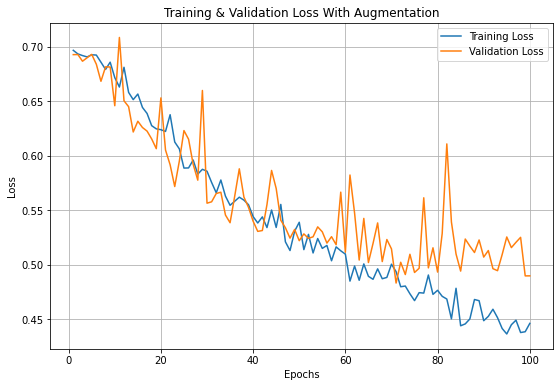

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss'])+1)

plt.figure(figsize = (9,6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss With Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


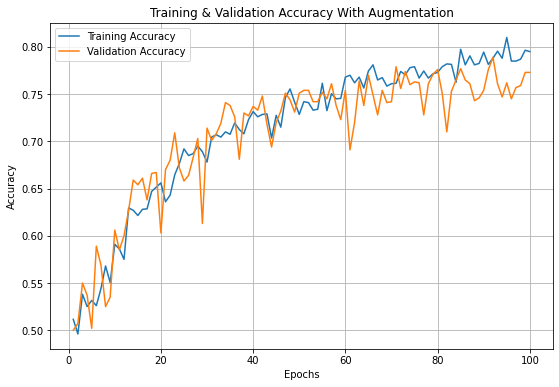

In [15]:
epochs = range(1, len(Hist_dandc.history['loss']) + 1)
plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.title('Training & Validation Accuracy With Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

In [16]:
# evaluate
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 20,
                                                  class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [17]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 3s 64ms/step - loss: 0.5054 - accuracy: 0.7840
Loss = 0.50543
Accuracy = 0.78400


In [18]:
# drive 에 저장
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
model.save('/content/drive/My Drive/Colab Notebooks/models/002_dogs_and_cats_Augmentation.h5')

!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 81088
-rw------- 1 root root    34600 Aug  4 08:36 001_Model_iris.h5
-rw------- 1 root root 41499544 Aug  6 08:04 002_dogs_and_cats_Augmentation.h5
-rw------- 1 root root 41498784 Aug  6 06:45 002_dogs_and_cats_small.h5


In [20]:
# model load
from tensorflow.keras.models import load_model

model_small = load_model('/content/drive/My Drive/Colab Notebooks/models/002_dogs_and_cats_Augmentation.h5')

loss, accuracy = model_small.evaluate(test_generator, steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 3s 66ms/step - loss: 0.5054 - accuracy: 0.7840
Loss = 0.50543
Accuracy = 0.78400
